In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Load the data
file_path = '/content/Cleaned Data.xlsx'
df = pd.read_excel(file_path)


In [ ]:
df.head(10)


,H_WC_Date_Hr - Week Commencing,Demand,Forecast,Variance,Category,Date_Time
0,2021-08-30,9,7.0,28.6%,Cat1,2021-09-01 00:00:00
1,2021-08-30,38,39.0,-2.6%,Cat2,2021-09-01 00:00:00
2,2021-08-30,11,16.0,-31.3%,Cat3,2021-09-01 00:00:00
3,2021-08-30,1,2.0,-50.0%,Cat4,2021-09-01 00:00:00
4,2021-08-30,8,6.0,33.3%,Cat1,2021-09-01 01:00:00
5,2021-08-30,37,33.0,12.1%,Cat2,2021-09-01 01:00:00
6,2021-08-30,9,14.0,-35.7%,Cat3,2021-09-01 01:00:00
7,2021-08-30,1,2.0,-50.0%,Cat4,2021-09-01 01:00:00
8,2021-08-30,3,4.0,-25.0%,Cat1,2021-09-01 02:00:00
9,2021-08-30,35,29.0,20.7%,Cat2,2021-09-01 02:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   H_WC_Date_Hr - Week Commencing  47331 non-null  datetime64[ns]
 1   Demand                          47331 non-null  int64         
 2   Forecast                        47204 non-null  float64       
 3   Variance                        47204 non-null  object        
 4   Category                        47331 non-null  object        
 5   Date_Time                       47331 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['H_WC_Date_Hr - Week Commencing', 'Variance', 'Category', 'Forecast'], axis = 1)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Demand     47331 non-null  int64         
 1   Date_Time  47331 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 739.7 KB


,Demand,Date_Time
count,47331.000000,47331
mean,20.523082,2022-05-01 16:40:33.922799360
min,1.000000,2021-09-01 00:00:00
25%,5.000000,2021-12-31 23:30:00
50%,13.000000,2022-05-01 03:00:00
75%,27.000000,2022-08-30 08:00:00
max,111.000000,2022-12-31 23:00:00
std,21.403041,NaN


In [ ]:
weekly_responses = df.resample('W', on='Date_Time').sum().reset_index()
weekly_responses.head(20)

,Date_Time,Demand
0,2021-09-05,10262
1,2021-09-12,14695
2,2021-09-19,14437
3,2021-09-26,14436
4,2021-10-03,14319
5,2021-10-10,14387
6,2021-10-17,14768
7,2021-10-24,14584
8,2021-10-31,14312
9,2021-11-07,14353


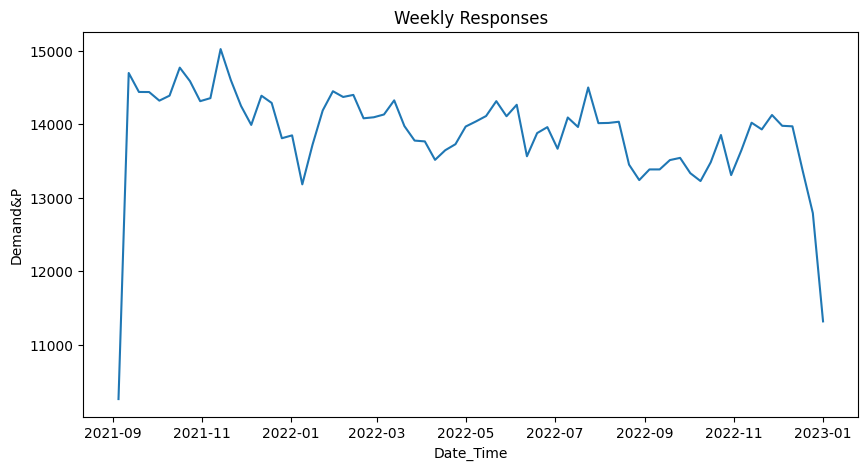

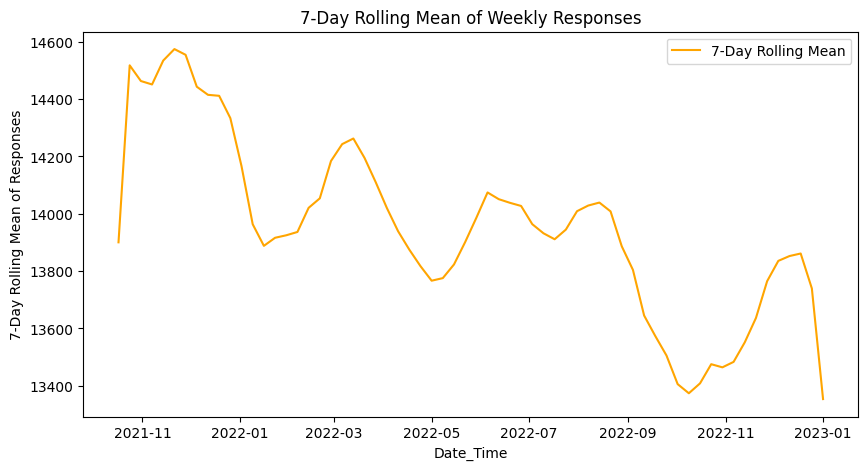

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(weekly_responses['Date_Time'], weekly_responses['Demand'])
plt.xlabel('Date_Time')
plt.ylabel('Demand&P')
plt.title('Weekly Responses')
plt.show()

# Additional visualization: rolling mean
weekly_responses['rolling_mean'] = weekly_responses['Demand'].rolling(window=7).mean()
plt.figure(figsize=(10, 5))
plt.plot(weekly_responses['Date_Time'], weekly_responses['rolling_mean'], label='7-Day Rolling Mean', color='orange')
plt.xlabel('Date_Time')
plt.ylabel('7-Day Rolling Mean of Responses')
plt.title('7-Day Rolling Mean of Weekly Responses')
plt.legend()
plt.show()

In [ ]:
# Checking the difference in the responses
weekly_responses['responses_diff'] = weekly_responses['Demand'].diff()
weekly_Responses =weekly_responses.dropna()
weekly_responses.head(10)

,Date_Time,Demand,rolling_mean,responses_diff
0,2021-09-05,10262,NaN,NaN
1,2021-09-12,14695,NaN,4433.0
2,2021-09-19,14437,NaN,-258.0
3,2021-09-26,14436,NaN,-1.0
4,2021-10-03,14319,NaN,-117.0
5,2021-10-10,14387,NaN,68.0
6,2021-10-17,14768,13900.571429,381.0
7,2021-10-24,14584,14518.000000,-184.0
8,2021-10-31,14312,14463.285714,-272.0
9,2021-11-07,14353,14451.285714,41.0


In [ ]:
# Ensure the 'responses_diff' column is calculated without dropping values prematurely
weekly_responses['responses_diff'] = weekly_responses['Demand'].diff()

# Create supervised data
supervised_data = weekly_responses[['responses_diff']].copy()  # Use .copy() to ensure a new DataFrame
for i in range(1, 11):
    supervised_data[f'week_{i}'] = supervised_data['responses_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)


In [ ]:
# Spliting data into train, validation, and test sets
train_data = supervised_data[:-24]
val_data = supervised_data[-24:-12]
test_data = supervised_data[-15:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Splitting features and targets
X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
X_val, y_val = val_data_scaled[:, 1:], val_data_scaled[:, 0]
X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# SVR with hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]}
svr_model = SVR(kernel='rbf')
grid_search = GridSearchCV(svr_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best SVR model
best_svr_model = grid_search.best_estimator_
y_pred_svr = best_svr_model.predict(X_test)

# Inverse scaling for Linear Regression and SVR
y_pred_lr = scaler.inverse_transform(np.hstack((y_pred_lr.reshape(-1, 1), X_test)))[:, 0]
y_pred_svr = scaler.inverse_transform(np.hstack((y_pred_svr.reshape(-1, 1), X_test)))[:, 0]

In [ ]:
# Get actual responses for comparison
actual_responses = weekly_responses['Demand'][-15:].reset_index(drop=True)

# Calculating the final predictions
result_list_lr = [y_pred_lr[i] + actual_responses[i] for i in range(len(y_pred_lr))]
result_list_svr = [y_pred_svr[i] + actual_responses[i] for i in range(len(y_pred_svr))]

Predict_df = pd.DataFrame({
    'Date_Time': weekly_responses['Date_Time'][-15:].reset_index(drop=True),
    'Original Demand': actual_responses,
    'Linear Prediction': result_list_lr,
    'SVR Prediction': result_list_svr
})

In [ ]:
# Evaluating metrics for Linear Regression
lr_mse = np.sqrt(mean_squared_error(actual_responses, result_list_lr))
lr_mae = mean_absolute_error(actual_responses, result_list_lr)
lr_r2 = r2_score(actual_responses, result_list_lr)
lr_mape = np.mean(np.abs((actual_responses - result_list_lr) / actual_responses)) * 100

print(f'Linear Regression MSE: {lr_mse}')
print(f'Linear Regression MAE: {lr_mae}')
print(f'Linear Regression R2: {lr_r2}')
print(f'Linear Regression MAPE: {lr_mape}')

# Evaluating metrics for SVR
svr_mse = np.sqrt(mean_squared_error(actual_responses, result_list_svr))
svr_mae = mean_absolute_error(actual_responses, result_list_svr)
svr_r2 = r2_score(actual_responses, result_list_svr)
svr_mape = np.mean(np.abs((actual_responses - result_list_svr) / actual_responses)) * 100

print(f'SVR MSE: {svr_mse}')
print(f'SVR MAE: {svr_mae}')
print(f'SVR R2: {svr_r2}')
print(f'SVR MAPE: {svr_mape}')

Linear Regression MSE: 173.01729175682308
Linear Regression MAE: 150.61891456944758
Linear Regression R2: 0.9342947175889486
Linear Regression MAPE: 1.124386601539663
SVR MSE: 26.62792586289633
SVR MAE: 23.009910787076297
SVR R2: 0.9984436905836909
SVR MAPE: 0.1704603987150618


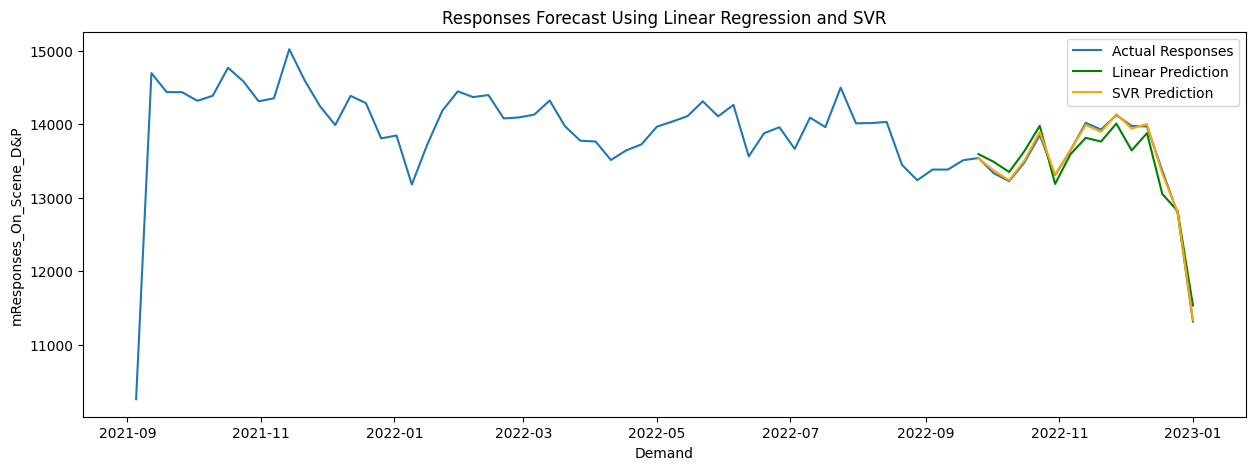

In [ ]:
# Plot actual responses and predictions
plt.figure(figsize=(15, 5))
plt.plot(weekly_responses['Date_Time'], weekly_responses['Demand'], label='Actual Responses')
plt.plot(Predict_df['Date_Time'], Predict_df['Linear Prediction'], label='Linear Prediction', color='green')
plt.plot(Predict_df['Date_Time'], Predict_df['SVR Prediction'], label='SVR Prediction', color='orange')

plt.title('Responses Forecast Using Linear Regression and SVR')
plt.xlabel('Demand')
plt.ylabel('mResponses_On_Scene_D&P')
plt.legend()
plt.show()

In [ ]:
Predict_df.head(12)



,Date_Time,Original Demand,Linear Prediction,SVR Prediction
0,2022-09-25,13541,13593.454461,13539.051015
1,2022-10-02,13333,13488.427747,13369.909532
2,2022-10-09,13226,13351.144624,13237.971450
3,2022-10-16,13481,13636.232037,13506.806203
4,2022-10-23,13852,13979.027964,13895.934610
5,2022-10-30,13307,13188.446863,13310.360012
6,2022-11-06,13644,13591.308589,13648.818285
7,2022-11-13,14019,13815.478889,13990.731585
8,2022-11-20,13928,13764.637066,13896.334822
9,2022-11-27,14124,14008.858360,14138.674398
